# Source localization pipeline - Stage2
- coregistration
- source localization
- report generation
 
 


#### Author
Rudi Kreidenhuber <Rudi.Kreidenhuber@gmail.com>
#### License
BSD (3-clause)

# Overall config

In [1]:
import os
import glob
import mne
from mne_bids import BIDSPath, write_raw_bids, read_raw_bids
from src import Folderer, Anatomist, Reporter, SubjectDropDowner
from src import Utils as u
import pickle
import pyvista
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np

# configuration
input_dir = "/home/meg/Schreibtisch/new_patients/processed"
bids_root = "/run/media/meg/DATA/MEG/BIDS_clinic"
n_jobs = openmp = 30
extras_directory = os.path.join(input_dir, "..", "extras")
FS_SUBJECTS_DIR = "/usr/local/freesurfer/subjects/"
spacing = "ico4"

print("Configuration:")
for dir in [input_dir, bids_root, extras_directory, FS_SUBJECTS_DIR]:
    print(f"{dir}")


def get_subject_list(input_dir = input_dir) -> list:
    fiflist = [os.path.basename(f) for f in glob.glob(os.path.join(input_dir, "*.fif"))]
    fiflist = [f.split("_")[0] for f in fiflist]
    print(fiflist)
    return fiflist

subjectlist = get_subject_list()

dl = SubjectDropDowner.SubjectDropDowner(subjectlist)
drop_menu = dl.create_subject_dropdown_widget()
print(f"\n\nChoose patient/ subject to process further:")
drop_menu

Configuration:
/home/meg/Schreibtisch/new_patients/processed
/run/media/meg/DATA/MEG/BIDS_clinic
/home/meg/Schreibtisch/new_patients/processed/../extras
/usr/local/freesurfer/subjects/
['sub-VA09051993', 'sub-VA09051993', 'sub-KA16091969', 'sub-KA16091969', 'sub-FT05042011']


Choose patient/ subject to process further:


In [2]:
subject = dl.get_subject_dropdown().value



# delete me later
subject = "sub-FT05042011"




if not subject.startswith("sub-"):
    ject = subject
    subject = "sub-" + subject
else:
    ject = subject.strip("sub-")

print(f"Chosen Subject: {subject}")

# create output folders
dfc = Folderer.DerivativesFoldersCreator(BIDS_root=bids_root, 
                                            extras_directory=extras_directory, 
                                            subject=subject)
dfc.make_derivatives_folders()

# copy freesurfer files to local subjects_dir
try:
    segmentation = os.path.join(os.path.abspath(FS_SUBJECTS_DIR), subject)
    target = os.path.join(dfc.fanat, subject)
    if not os.path.isdir(target):
        os.mkdir(target)
    dfc._recursive_overwrite(segmentation, target)
except Exception as e:
    print(f"Couldn't copy freesurfer segmentation\n--> {e}.")
    
# create source models
sourcerer = Anatomist.SourceModeler(subjects_dir=dfc.fanat, subject=subject, spacing=spacing, n_jobs=n_jobs)
sourcerer.calculate_source_models()

Chosen Subject: sub-FT05042011
Copying: /home/meg/Schreibtisch/new_patients/processed/../extras/anatomy_templates
Copying: /home/meg/Schreibtisch/new_patients/processed/../extras/anatomy_templates
The FREESURFER_HOME environment variable is not set.
Creating the BEM geometry...
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
Going from 5th to 4th subdivision of an icosahedron (n_tri: 20480 -> 5120)
outer skin  CM is   5.41  -7.77  26.90 mm
outer skull CM is   5.36  -7.71  26.38 mm
inner skull CM is   6.18  -9.17  35.35 mm
Checking that surface outer skull is inside surface outer skin  ...
Checking that surface inner skull is inside surface outer skull ...
Failed to calculate 3-layer BEM model for sub-FT05042011 --> Surface inner skull is not completely inside surface outer skull
Failed to calculate 3-layer BEM solution for sub-FT05042011 --> fname does not exist: /run/media/meg/DATA/ME

# Coregistration

In [ ]:
transfile = os.path.join(dfc.ftrans, subject + "-trans.fif")
print("Starting coregistration...")
if os.path.isfile(transfile):
    print(f"Skipping coregistration, because a transfile ({transfile}) already exists")
else:
    print(f"\n\n\n--> Transfile should be called: {transfile}\n\n\n")
    try:
        rawfile = os.path.join(input_dir, subject + "_prepped.fif")
        mne.gui.coregistration(subject=subject, subjects_dir=dfc.fanat, inst=rawfile, block=True)
    except Exception as e:
        print(f"Failed launching Coregistration: {e}")

# .fif - File processing

## load data...

In [3]:
rawfile = os.path.join(input_dir, subject + "_prepped.fif")
raw = mne.io.read_raw(rawfile, preload=False, on_split_missing="ignore").load_data()
raw.plot()

Opening raw data file /home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped.fif...
    Range : 3000 ... 1128599 =     10.000 ...  3761.997 secs
Ready.
Reading 0 ... 1125599  =      0.000 ...  3751.997 secs...
Using qt as 2D backend.


In [ ]:
raw.info["projs"]

## merge events

#### helpers

In [ ]:
def transform_eventfile(event_file):
    """
    Receives a .csv or .txt files as exported i.e. via brainstorm and
    transforms it according to mne-needs.

    Returns a tuple:
    new_eve_file, event_dict
    --> = transformed event-file, dictionary with Eventnames
    """

    eve = pd.read_csv(event_file, header=0)
    le = LabelEncoder()
    labels = eve.iloc[:,0]
    print(f"Labels --> {labels}")
    l_enc = le.fit_transform(labels)
    l_enc = l_enc
    new_eve_file = pd.DataFrame([eve.iloc[:,1], eve.iloc[:,0], (l_enc +1)]).T
    new_eve_file.reset_index(drop=True, inplace = True)
    new_eve_file.iloc[:,0] = (new_eve_file.iloc[:,0]*1000).astype(int)
    new_eve_file.iloc[0,2] = 0  #create one pseudo-event (that is going to be dropped later for some reason)
    new_eve_file.iloc[:,0] = new_eve_file.iloc[:,0].astype(int)
    new_eve_file.iloc[:,1] = new_eve_file.iloc[:,1].astype(str)
    new_eve_file.iloc[:,2] = new_eve_file.iloc[:,2].astype(int)
    new_eve_file.iloc[:,1] = int("0")

    name_of_events = np.unique(eve.iloc[:,0])
    name_of_events = np.sort(name_of_events)
    event_dict=dict()
    event_dict['ignore_me']=0
    for i in range(name_of_events.size):
        key = (name_of_events[i])
        val = i + 1
        event_dict[key] = val
    return new_eve_file, event_dict

def raw_to_epoch(raw, rawfile=None, picks=["meg", "eeg"]) -> mne.Epochs:
    """
    Receives a raw file, finds the corresponding event-file
    Returns an epoch-file
    """
    eve_name = rawfile.split(".fif")[0] + ".csv"
    if not os.path.isfile(eve_name):
        eve_name = rawfile.split(".fif")[0] + ".txt"
    if os.path.isfile(eve_name): # if fif-file matches event-file --> add events to fif-file
        try:
            print(f"\n\nNow epoching events from {rawfile}\n\n")
            event_file, event_dict = transform_eventfile(eve_name)
            print(f"\n\nevent_file: {event_file}")
            print(f"\n\nevent_dict: {event_dict}")
            epochs = mne.Epochs(raw, events=event_file,
                                event_id=event_dict, 
                                tmin=-1.5, tmax=1, 
                                baseline=(-1.5,-0.7), 
                                on_missing = "ignore", 
                                picks=picks,
                                reject=None,
                                event_repeated="merge",
                                #reject_by_annotation=False,  # nothing is dropped, but some epochs are empty
                                )
            del(raw)
            return epochs
        except Exception as e:
            print(f"failed at returning an epochs object for: {rawfile}\nbecause of {e}")

#### epoching

In [ ]:
epo_filename = os.path.join(dfc.spikes, str(subject) + "-epo.fif")
if os.path.isfile(epo_filename):
    print(f"Epoched file exists at: {epo_filename}, aborting.")
    epochs = mne.read_epochs(epo_filename)
else:
    epochs = raw_to_epoch(raw, rawfile=rawfile)
    epochs.save(epo_filename, overwrite=True)
    #else:
    #    print(f"Epoch file was not found, did you mark the spikes and save the file as {epo_filename} ?")



    ##################
    ### FIX ME!!!! ###
    ##################


    #some epochs are empty (no data), although they shouldn't be.
    # this breaks saving,

In [ ]:
epochs

In [ ]:
raw.get_data().shape

In [ ]:
epochs.get_data().shape

In [ ]:
#epochs["Single_Spike_3_re"].plot()
epochs.plot()

In [ ]:
epochs.drop_log

In [ ]:
epo_filename = os.path.join(dfc.spikes, str(subject) + "-epo.fif")
print(epo_filename)
epochs.save(epo_filename, overwrite=True)

## ECG artifact correction

### configuration

In [4]:
ecg_channel = "ECG003"
n_grad: int = 1
n_mag: int = 1
n_eeg: int = 1

Including 0 SSP projectors from raw file
Running ECG SSP computation
Using channel ECG003 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 3000 samples (10.000 sec)

Number of ECG events detected : 4639 (average pulse 74 / min.)
Computing projector
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 1 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 1.00
- Lo

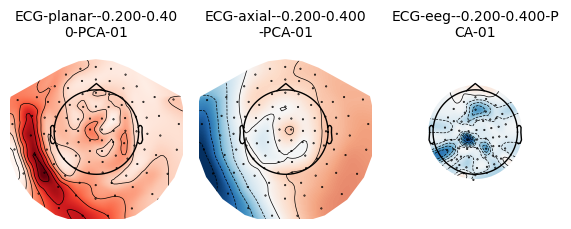

In [5]:
try:
    ecg_projs, _ = mne.preprocessing.compute_proj_ecg(raw, n_grad=n_grad, n_mag=n_mag, 
                                                      n_eeg=n_eeg, reject=None, n_jobs=n_jobs)
    raw.add_proj(ecg_projs, remove_existing=False)
    fig = mne.viz.plot_projs_topomap(ecg_projs, info=raw.info, show=True)
    savename = os.path.join(dfc.fprep, "ECG_projs_Topomap.png")
    fig.savefig(savename)
except Exception as e:
    print(f"ECG - Atrifact correction failed --> {e}")

## EOG artifact correction

Using EOG channels: EOG001, EOG002
EOG channel index for this subject is: [0 1]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 3000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 910 significant peaks
Number of EOG events detected: 910
Not setting metadata
910 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 3)
Using data from preloaded Raw for 910 events and 301 original time points ...
[Parallel(n_jobs=1)]: Using 

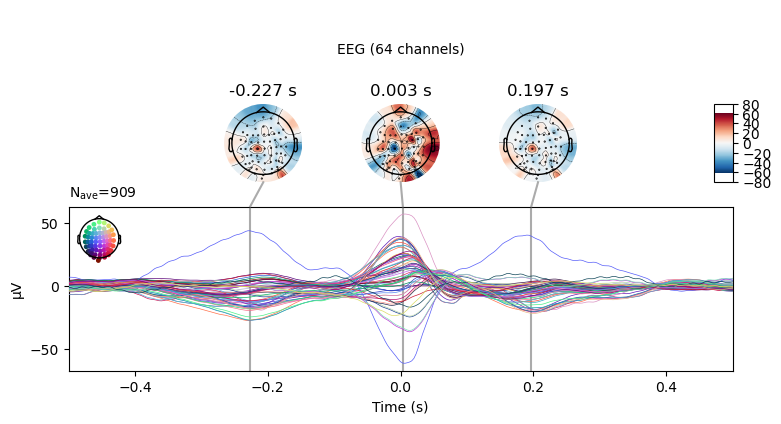

Removing projector <Projection | ECG-planar--0.200-0.400-PCA-01, active : True, n_channels : 204, exp. var : 88.07%>
Removing projector <Projection | ECG-eeg--0.200-0.400-PCA-01, active : True, n_channels : 64, exp. var : 43.78%>


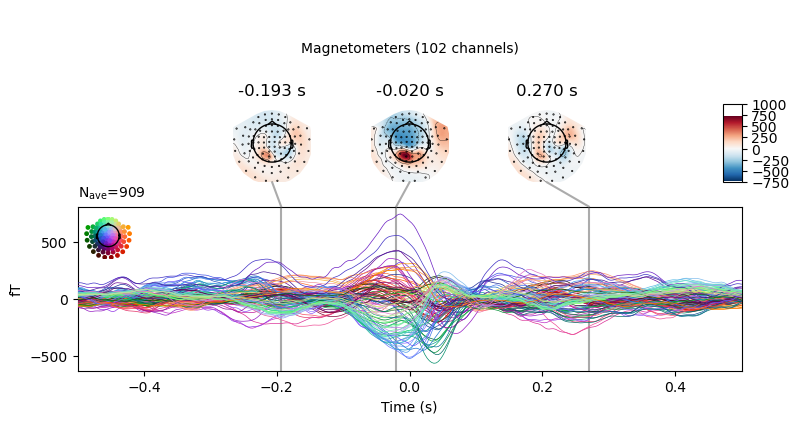

Removing projector <Projection | ECG-axial--0.200-0.400-PCA-01, active : True, n_channels : 102, exp. var : 94.32%>
Removing projector <Projection | ECG-eeg--0.200-0.400-PCA-01, active : True, n_channels : 64, exp. var : 43.78%>


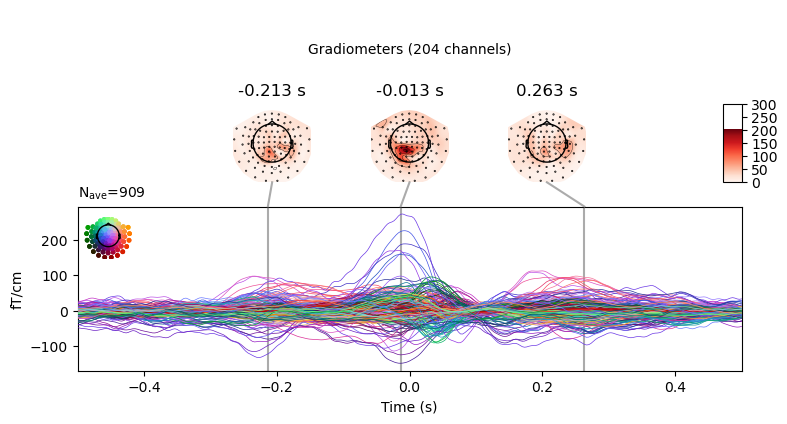

In [6]:
try:
    eog_evoked = mne.preprocessing.create_eog_epochs(raw).average()
    # eog_evoked.apply_baseline((None, None))
    eog_projs, _ = mne.preprocessing.compute_proj_eog(
        raw,
        n_grad=n_grad,
        n_mag=n_mag,
        n_eeg=n_eeg,
        n_jobs=n_jobs,
        reject=None,
    )
    raw.add_proj(
        eog_projs, remove_existing=False
    )  # --> don't do this in the early stages - see documentation
    figs = eog_evoked.plot_joint(show=True)
    for idx, fig in enumerate(figs):
        savename = os.path.join(
            dfc.fprep, "EOG Topomap_" + str(idx) + ".png"
        )
        fig.savefig(savename)
except Exception as e:
    print(f"EOG - Atrifact correction failed --> {e}")

# store projs
all_projs = raw.info["projs"]
savename = os.path.join(dfc.fprep, "all_projs.pkl")
with open(savename, "wb") as s:
    pickle.dump(all_projs, s)

## save raw file

In [7]:

#rawfile = "/home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped.fif"
rawfile = rawfile.strip(".fif") + "_artcorr.fif"
raw.save(rawfile, overwrite=True)
raw = mne.io.read_raw(rawfile, preload=False)

derivatives_root = os.path.join(bids_root, "derivatives")
# meg
bids_path = BIDSPath(
    subject=ject,
    session="resting",
    task="resting",
    root=derivatives_root,
    processing="concat")

write_raw_bids(raw, bids_path, overwrite=True)

Writing /home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped_artcorr.fif
Closing /home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped_artcorr.fif
[done]
Opening raw data file /home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped_artcorr.fif...
    Read a total of 6 projection items:
        ECG-planar--0.200-0.400-PCA-01 (1 x 204)  idle
        ECG-axial--0.200-0.400-PCA-01 (1 x 102)  idle
        ECG-eeg--0.200-0.400-PCA-01 (1 x 64)  idle
        EOG-planar--0.200-0.200-PCA-01 (1 x 204)  idle
        EOG-axial--0.200-0.200-PCA-01 (1 x 102)  idle
        EOG-eeg--0.200-0.200-PCA-01 (1 x 64)  idle
    Range : 3000 ... 1128599 =     10.000 ...  3761.997 secs
Ready.
Opening raw data file /home/meg/Schreibtisch/new_patients/processed/sub-FT05042011_prepped_artcorr.fif...
    Read a total of 6 projection items:
        ECG-planar--0.200-0.400-PCA-01 (1 x 204)  idle
        ECG-axial--0.200-0.400-PCA-01 (1 x 102)  idle
        ECG-eeg--0.200-0.4

ValueError: Previous BIDS version used, please redo the conversion to BIDS in a new directory after ensuring all software is updated

# Frequency spectrum

## configuration

In [ ]:
use_single_shell_model = True   # fall back to single shell head model, if nothing better is available
freq_bands = dict(  # the frequency bands of interest for the analysis
    delta=(1, 4), 
    theta=(4, 7), 
    alpha=(8, 12), 
    beta=(13, 29), 
    gamma=(30, 50))

In [ ]:
bem_sol = os.path.join(dfc.fsrc, subject + "-3-layer-BEM-sol.fif")
if not os.path.isfile(bem_sol) and use_single_shell_model:
    print("Working with a single shell head model")
    bem_sol = os.path.join(dfc.fsrc, subject + "-single-shell-BEM-sol.fif")

fwd_name = os.path.join(dfc.fsrc, subject + "-fwd.fif")
srcfilename = os.path.join(dfc.fsrc, subject + "-" + spacing + "-src.fif")
filebase = str(subject) + "_Freqs"
all_stcs_filename = filebase + "-stc-psd-MNE.pkl"
all_stcs_filename = os.path.join(dfc.freq, all_stcs_filename)
sensor_psd_filename = filebase + "-sensor-psd-MNE.pkl"
sensor_psd_filename = os.path.join(dfc.freq, sensor_psd_filename)
transfile = os.path.join(dfc.ftrans, subject + "-trans.fif")
derivatives_root = os.path.join(bids_root, "derivatives")

bids_path = BIDSPath(
    subject=ject,
    session="resting",
    task="resting",
    root=derivatives_root,
    processing="concat")

if not os.path.isfile(all_stcs_filename) or not os.path.isfile(
                                                sensor_psd_filename):
    raw = read_raw_bids(bids_path, preload=True)
    
    if os.path.isfile(fwd_name):
        fwd = mne.read_forward_solution(fwd_name)
    else:
        fwd = mne.make_forward_solution(
            raw.info,
            src=srcfilename,
            bem=bem_sol,
            trans=transfile,
            meg=True,
            eeg=False,
            mindist=0.2,
            ignore_ref=False,
            n_jobs=n_jobs,
            verbose=True,
        )
        mne.write_forward_solution(fwd_name, fwd)
    noise_cov = mne.compute_raw_covariance(
        raw, method="empirical", n_jobs=n_jobs
    )
    inv = mne.minimum_norm.make_inverse_operator(
        raw.info, forward=fwd, noise_cov=noise_cov, loose="auto", depth=0.8
    )
    snr = 3.0
    stc_psd, sensor_psd = mne.minimum_norm.compute_source_psd(
        raw,
        inv,
        lambda2=lambda2,
        method="MNE",
        fmin=1,
        fmax=45,
        n_fft=2048,
        n_jobs=n_jobs,
        return_sensor=True,
        verbose=True,
    )
    pickle.dump(stc_psd, open(all_stcs_filename, "wb"))
    pickle.dump(sensor_psd, open(sensor_psd_filename, "wb"))
else:
    stc_psd = pickle.load(open(all_stcs_filename, "rb"))
    sensor_psd = pickle.load(open(sensor_psd_filename, "rb"))

# Visualization
topos = dict()
stcs = dict()
topo_norm = sensor_psd.data.sum(axis=1, keepdims=True)
stc_norm = stc_psd.sum()
for band, limits in freq_bands.items():  # normalize...
    data = sensor_psd.copy().crop(*limits).data.sum(axis=1, keepdims=True)
    topos[band] = mne.EvokedArray(100 * data / topo_norm, sensor_psd.info)
    stcs[band] = 100 * stc_psd.copy().crop(*limits).sum() / stc_norm.data
brain = dict()
x_hemi_freq = dict()
#mne.viz.set_3d_backend("pyvista")
for band in freq_bands.keys():
# dorsal    
    brain[band] = u.plot_freq_band_dors(
        stcs[band],
        band=band,
        subject=subject,
        subjects_dir=dfc.fanat,
        filebase=filebase,
    )
    freqfilename3d = filebase + "_" + band + "_freq_topomap_3d_dors.png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = brain[band].save_image(freqfilename3d)
# lateral    
    brain_lh, brain_rh = u.plot_freq_band_lat(
        stcs[band],
        band=band,
        subject=subject,
        subjects_dir=dfc.fanat,
        filebase=filebase,
    )
    freqfilename3d = filebase + "_" + band + "_freq_topomap_3d_lat_lh.png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = brain_lh.save_image(freqfilename3d)
    freqfilename3d = filebase + "_" + band + "_freq_topomap_3d_lat_rh.png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = brain_rh.save_image(freqfilename3d)
# medial    
    brain_lh, brain_rh = u.plot_freq_band_med(
        stcs[band],
        band=band,
        subject=subject,
        subjects_dir=dfc.fanat,
        filebase=filebase,
    )
    freqfilename3d = filebase + "_" + band + "_freq_topomap_3d_med_lh.png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = brain_lh.save_image(freqfilename3d)
    freqfilename3d = filebase + "_" + band + "_freq_topomap_3d_med_rh.png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = brain_rh.save_image(freqfilename3d)
    
# Cross hemisphere comparison
    # make sure fsaverage_sym exists in local subjects dir:
    print(f"Calculating cross hemisphere comparison for {band}.")
    target = os.path.join(dfc.fanat, "fsaverage_sym")
    if not os.path.isdir(target):
        # try to find it in $SUBJECTS_DIR and copy
        os_subj_dir = os.environ.get("SUBJECTS_DIR")
        fs_avg_sym_dir = os.path.join(os_subj_dir, "fsaverage_sym")
        u.recursive_overwrite(fs_avg_sym_dir, target)
    if not os.path.isdir(target):
        print("fsaverage_sym not found - aborting")
        raise Exception
    mstc = stcs[band].copy()
    mstc = mne.compute_source_morph(
        mstc,
        subject,
        "fsaverage_sym",
        smooth=5,
        warn=False,
        subjects_dir=dfc.fanat,
    ).apply(mstc)
    morph = mne.compute_source_morph(
        mstc,
        "fsaverage_sym",
        "fsaverage_sym",
        spacing=mstc.vertices,
        warn=False,
        subjects_dir=dfc.fanat,
        xhemi=True,
        verbose="error",
    )
    stc_xhemi = morph.apply(mstc)
    diff = mstc - stc_xhemi
    title = "blue = RH; " + subject + " -Freq-x_hemi- " + band
    x_hemi_freq[band] = diff.plot(
        hemi="lh",
        subjects_dir=dfc.fanat,
        size=(1200, 800),
        time_label=title,
        add_data_kwargs=dict(time_label_size=10),
    )
    freqfilename3d = filebase + "_x_hemi_" + band + ".png"
    freqfilename3d = os.path.join(dfc.freq, freqfilename3d)
    image = x_hemi_freq[band].save_image(freqfilename3d)
pyvista.close_all()

# Source localization

## configuration

In [ ]:
source_loc_methods = ["dSPM", "eLORETA", "ECD"] # ["dSPM", "eLORETA", "ECD"] --> expects a list
snr = 3
lambda2 = 1.0 / snr ** 2
peaks_tmin, peaks_tmax = -0.025, 0.
peaks_mode = "abs"  # How to deal with the sign of the data:  "pos", "neg", or "abs"
peaks_nr_of_points = 5

dip_times = {
    "min20ms": (-0.025,-0.020),  # Time windows in Miliseconds for Equivalent current dipole fit
    "min15ms": (-0.019, -0.015),
    "min10ms": (-0.014, -0.010),
    "min5ms": (-0.009, -0.005),
    "peak": (-0.004, 0.000),
}

use_single_shell_model = True  # if 3-layer-BEM fails for some reason
picks=["meg", "eeg"]

noise_cov_file = os.path.join(dfc.spikes, "Spikes_noise_covariance.pkl")
srcfilename = os.path.join(dfc.fsrc, subject + "-" + spacing + "-src.fif")
epo_filename = os.path.join(dfc.spikes, str(subject) + "-epo.fif")
ject = subject.strip("sub-")

### create epoch file

In [ ]:
concat_epochs = mne.read_epochs(epo_filename)
concat_epochs.event_id.keys()

In [ ]:
# noise covariance
if not os.path.isfile(noise_cov_file):
    noise_cov = mne.compute_covariance(
        concat_epochs, tmax=-1.0, method="auto", n_jobs=n_jobs, rank="full"
    )
    pickle.dump(noise_cov, open(noise_cov_file, "wb"))
else:
    with open(noise_cov_file, "rb") as f:
        noise_cov = pickle.load(f)
        
for event in concat_epochs.event_id.keys():
    eventname = str(event)
    if (
        eventname == "ignore_me"
        or eventname == "AAA"
        or eventname.startswith(".")
    ):
        print(f"Omitting event {event}")
    else:
        try:
            print(f"Now localizing event: {event}")
            e = (
                concat_epochs[eventname]
                .load_data()
                .crop(tmin=-0.5, tmax=0.5)
                .average()
            )
            e_folder = os.path.join(dfc.spikes, eventname)
            evoked_filename = os.path.join(e_folder, ject + "_" + eventname + "-ave.fif")
            cp_folder = os.path.join(dfc.spikes, eventname, "custom_pics")
            cts_folder = os.path.join(dfc.spikes, eventname, "custom_time_series")
            gp_folder = os.path.join(dfc.spikes, eventname, "generic_pics")
            folders = [e_folder, cp_folder, cts_folder, gp_folder]
            if not os.path.isdir(e_folder):
                for f in folders:
                    os.mkdir(f)
            e.save(evoked_filename)
            src = mne.read_source_spaces(srcfilename)
            bem_sol = os.path.join(dfc.fsrc, subject + "-3-layer-BEM-sol.fif")
            if not os.path.isfile(bem_sol) and use_single_shell_model:
                bem_sol = os.path.join(dfc.fsrc, subject + "-single-shell-BEM-sol.fif")

            fwd_name = os.path.join(dfc.fsrc, subject + "-fwd.fif")
            if os.path.isfile(fwd_name):
                fwd = mne.read_forward_solution(fwd_name)
            else:
                fwd = mne.make_forward_solution(
                    e.info,
                    src=src,
                    bem=bem_sol,
                    trans=transfile,
                    meg=True,
                    eeg=False,
                    mindist=0.2,
                    ignore_ref=False,
                    n_jobs=n_jobs,
                    verbose=True,
                )
            # inv for cortical surface
            inv = mne.minimum_norm.make_inverse_operator(
                e.info, forward=fwd, noise_cov=noise_cov, loose=0.2, depth=0.8
            )
            # inv with volume source space
            vol_srcfilename = os.path.join(dfc.fsrc, subject + "-vol-src.fif")
            src_vol = mne.read_source_spaces(vol_srcfilename)
            fwd_vol = mne.make_forward_solution(
                e.info,
                src=src_vol,
                bem=bem_sol,
                trans=transfile,
                meg=True,
                eeg=False,
                mindist=0.2,
                ignore_ref=False,
                n_jobs=n_jobs,
                verbose=True,
            )
            inv_vol = mne.minimum_norm.make_inverse_operator(
                e.info, forward=fwd_vol, noise_cov=noise_cov, loose=1, depth=0.8
            )
            for m in source_loc_methods:
                stc_name = "stc_" + m
                if m == "dSPM":
                    # calculate vector solution in volume source space
                    try:
                        print("Now calculating dSPM vector solution...")
                        stc_name = mne.minimum_norm.apply_inverse(
                            e,
                            inv_vol,
                            lambda2,
                            method="dSPM",
                            pick_ori="vector",
                        )
                        surfer_kwargs = dict(
                            subjects_dir=dfc.fanat,
                            src=inv_vol["src"],
                            clim=dict(kind="percent", lims=[90, 96, 99.85]),
                            colorbar=True,
                            initial_time=0,
                            #time_unit="ms",
                            #size=(1000, 800),
                            #smoothing_steps=10,
                        )
                        brain = stc_name.plot(**surfer_kwargs)
                        #label = str(ject + " - " + eventname + " - Vector solution")
                        #brain.add_text(0.1, 0.9, label, "title", font_size=10)
                        img_f_name = ("img_stc_" + ject + "_" + eventname + "_"+ m + ".png")
                        img_f_name = os.path.join(gp_folder, img_f_name)
                        #brain.save_image(img_f_name)
                        stc_f_name = (
                            "stc_" + ject + "_" + eventname + "_" + m + ".h5"
                        )
                        stc_f_name = os.path.join(e_folder, stc_f_name)
                        stc_name = stc_name.crop(tmin=stc_tmin, tmax=stc_tmax)
                        print("Saving dSPM vector solution.")
                        stc_name.save(stc_f_name)
                    except Exception as ex:
                        print(f"dSPM failed --> {ex}")
                else:
                    stc_name = mne.minimum_norm.apply_inverse(
                        e, inv, lambda2, method=m, pick_ori=None
                    )
                    surfer_kwargs = dict(
                        hemi="split",
                        subjects_dir=dfc.fanat,
                        clim=dict(kind="percent", lims=[90, 96, 99.85]),
                        views=["lat", "med"],
                        colorbar=True,
                        initial_time=0,
                        time_unit="ms",
                        size=(1000, 800),
                        smoothing_steps=10,
                    )
                    brain = stc_name.plot(**surfer_kwargs)
                    label = str(ject + " - " + eventname + " - " + m)
                    brain.add_text(0.1, 0.9, label, "title", font_size=10)
                    img_f_name = (
                        "img_stc_" + ject + "_" + eventname + "_" + m + ".png"
                    )
                    img_f_name = os.path.join(gp_folder, img_f_name)
                    brain.save_image(img_f_name)
                    stc_f_name = "stc_" + ject + "_" + eventname + "_" + m
                    stc_f_name = os.path.join(e_folder, stc_f_name)
                    stc_name = stc_name.crop(tmin=stc_tmin, tmax=stc_tmax)
                    print("Saving eLORETA.")
                    stc_name.save(stc_f_name)
                    if m == "eLORETA":
                        try:
                            print(
                                "Now calculating eLORETA with peaks..."
                            )
                            rh_peaks = u.get_peak_points(
                                stc_name,
                                hemi="rh",
                                tmin=peaks_tmin,
                                tmax=peaks_tmax,
                                nr_points=peaks_nr_of_points,
                                mode=peaks_mode,
                            )
                            lh_peaks = u.get_peak_points(
                                stc_name,
                                hemi="lh",
                                tmin=peaks_tmin,
                                tmax=peaks_tmax,
                                nr_points=peaks_nr_of_points,
                                mode=peaks_mode,
                            )
                            label = str(
                                ject
                                + " - "
                                + eventname
                                + " - "
                                + m
                                + " - max. activation points"
                            )
                            brain.add_text(
                                0.1, 0.9, label, font_size=10
                            )  # , 'title'
                            for p in rh_peaks:
                                brain.add_foci(
                                    p,
                                    color="green",
                                    coords_as_verts=True,
                                    hemi="rh",
                                    scale_factor=0.6,
                                    alpha=0.9,
                                )
                            for p in lh_peaks:
                                brain.add_foci(
                                    p,
                                    color="green",
                                    coords_as_verts=True,
                                    hemi="lh",
                                    scale_factor=0.6,
                                    alpha=0.9,
                                )
                            stc_f_name = (
                                "stc_"
                                + ject
                                + "_"
                                + eventname
                                + "_"
                                + m
                                + "_with_peaks-ave"
                            )
                            stc_f_name = os.path.join(e_folder, stc_f_name)
                            stc_name.save(stc_f_name)
                            img_f_name = (
                                "img_stc_"
                                + ject
                                + "_"
                                + eventname
                                + "_"
                                + m
                                + "_with_peaks.png"
                            )
                            img_f_name = os.path.join(gp_folder, img_f_name)
                            brain.save_image(img_f_name)
                        except Exception as ex:
                            print(f"eLORETA with peaks failed --> {ex}")
            # Dipoles
            if "ECD" in source_loc_methods:
                print("Now calculating ECD.")
                try:
                    for start, stop in dip_times.values():
                        dip_epoch = e.copy().crop(start, stop).pick("meg")
                        ecd = mne.fit_dipole(
                            dip_epoch, noise_cov, bem_sol, trans=transfile
                        )[0]
                        best_idx = np.argmax(ecd.gof)
                        best_time = ecd.times[best_idx]
                        trans = mne.read_trans(transfile)
                        mri_pos = mne.head_to_mri(
                            ecd.pos,
                            mri_head_t=trans,
                            subject=subject,
                            subjects_dir=dfc.fanat,
                        )
                        t1_file_name = os.path.join(
                            dfc.fanat, subject, "mri", "T1.mgz"
                        )
                        stoptime = str(abs(int(stop * int(e.info["sfreq"]))))
                        if stoptime == "5":
                            stoptime = "05"
                        title = str(
                            eventname + " - ECD @ minus " + stoptime + " ms"
                        )
                        t1_fig = plot_anat(
                            t1_file_name, cut_coords=mri_pos[0], title=title
                        )
                        t1_f_name_pic = (
                            "img_ecd_"
                            + eventname
                            + "_"
                            + "_Dipol_"
                            + stoptime
                            + ".png"
                        )
                        t1_f_name_pic = os.path.join(
                            e_folder, "generic_pics", t1_f_name_pic
                        )
                        t1_fig.savefig(t1_f_name_pic)
                        fig_3d = ecd.plot_locations(
                            trans, subject, dfc.fanat, mode="orthoview"
                        )
                        fig_3d_pic = (
                            "img_3d_ecd_"
                            + eventname
                            + "_"
                            + "_Dipol_"
                            + stoptime
                            + ".png"
                        )
                        fig_3d_pic = os.path.join(
                            e_folder, "generic_pics", fig_3d_pic
                        )
                        fig_3d.savefig(fig_3d_pic)
                        plt.close("all")
                except Exception as ex:
                    print(f"ECD calculation failed --> {ex}")
        except Exception as ex:
            print(f"Source localization failed because of:\n {ex}")
else:
    print("Source localization skipped, as no -epo file was found.")
pyvista.close_all()

# Report

In [ ]:
from src import Reporter

In [ ]:
derivatives_root = os.path.join(bids_root, "derivatives")
reporter = Reporter.EpilepsyReportBuilder(
            derivatives_root=derivatives_root,
            subject=subject,
            extras_dir=extras_directory)
reporter.create_report()

In [ ]:
rawfile = "/run/media/meg/DATA/MEG/BIDS_clinic/derivatives/sub-VA09051993/spikes/Gr_1_li/VA09051993_Gr_1_li-ave.fif"
epo = mne.read_evokeds(rawfile)

In [ ]:
epo

In [ ]:
epo[0].plot_sensors(kind="topomap", ch_type="all")